## Objectives:

- To show the usage of `skorch` to wrap `PyTorch` models for making them `sklearn` compatible. 
- The `sklearn` library provides easy to use APIs for hyperparamter tuning, for building prediction pipelines and many more. Hence, this is a very useful utility to have. 

`skorch` official documentation: https://skorch.readthedocs.io
`skorch` GitHub: https://github.com/skorch-dev/skorch

The `skorch` library provides many other useful utilities like _Cyclical Learning Rates_ at callbacks, _Early Stopping_ as callbacks and so on. 

In [ ]:
# Install skorch
!pip install -U skorch

In [2]:
# Ignore unnecessary warnings and set the random seed
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(7)

We will be using the good old [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) for this purpose. 

In [3]:
# Data loading preview
import pandas as pd

columns = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
        "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                    header=None,
                    names=columns)

data.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Splitting w.r.t fixed indexes rather than random splitting
train = data[:30561]
test = data[30561:]

In [5]:
# Extracting the categorical and non-categorical features
cat_feats = [column for column in data.columns if data[column].dtypes=='object']
non_cat_feats = [column for column in data.columns if data[column].dtypes!='object']

In [6]:
# Label encode categories
from sklearn.preprocessing import LabelEncoder

train[cat_feats] = train[cat_feats].apply(LabelEncoder().fit_transform)
test[cat_feats] = test[cat_feats].apply(LabelEncoder().fit_transform)

In [7]:
# Split the data w.r.t fixed set of indices
X_train = train.iloc[:,0:-1]
y_train = train['Income']

X_test = test.iloc[:,0:-1]
y_test = test['Income']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30561, 14), (30561,), (2000, 14), (2000,))

In [8]:
# Standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_train = StandardScaler().fit_transform(X_train[non_cat_feats].values)
scaled_test = StandardScaler().fit_transform(X_test[non_cat_feats].values)

X_train[non_cat_feats] = scaled_train
X_test[non_cat_feats] = scaled_test

In [9]:
# PyTorch and skorch imports
from torch import nn
from skorch import NeuralNetClassifier

In [11]:
# Model definition
model = nn.Sequential(nn.Linear(X_train.shape[1], 64),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(64, 64),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(64, 2))
model

Sequential(
  (0): Linear(in_features=14, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2)
  (6): Linear(in_features=64, out_features=2, bias=True)
)

In [12]:
# Number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

5250


In [13]:
# Callbacks: EarlyStopping, ProgressBar
from skorch.callbacks import EarlyStopping, ProgressBar

es = EarlyStopping()
pbar = ProgressBar

In [15]:
# Build the model and train
from torch import optim

net = NeuralNetClassifier(
    model,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    max_epochs=40,
    batch_size=64,
    lr=0.01,
    callbacks=[es, pbar],
)

In [16]:
net.fit(X_train.values.astype(np.float32), y_train.values.astype(np.int64))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5475       0.7602        0.5029  1.3543


      2        0.5093       0.7759        0.4672  1.6117


      3        0.4756       0.7826        0.4523  1.5866


      4        0.4562       0.8009        0.4329  1.5327


      5        0.4429       0.8032        0.4223  1.6827


      6        0.4317       0.8104        0.4166  1.5552


      7        0.4241       0.8138        0.4075  1.6092


      8        0.4159       0.8124        0.4059  1.5997


      9        0.4119       0.8122        0.3969  1.6012


     10        0.4036       0.8147        0.3946  1.6090


     11        0.3997       0.8158        0.3911  1.4464


     12        0.3953       0.8191        0.3828  1.7403


     13        0.3926       0.8189        0.3921  1.3642


     14        0.3875       0.8189        0.3796  1.7266


     15        0.3838       0.8235        0.3746  1.3554


     16        0.3818       0.8228        0.3779  1.7008


     17        0.3783       0.8241        0.3664  1.3927


     18        0.3757       0.8261        0.3690  1.6810


     19        0.3727       0.8287        0.3598  1.6223


     20        0.3724       0.8243        0.3649  1.6744


     21        0.3692       0.8277        0.3645  1.7084


     22        0.3698       0.8269        0.3602  1.6771


     23        0.3671       0.8299        0.3474  1.2954


     24        0.3654       0.8238        0.3768  1.6489


     25        0.3630       0.8313        0.3552  1.2985


     26        0.3630       0.8307        0.3564  1.6768


     27        0.3614       0.8289        0.3537  1.7939


Stopping since valid_loss has not improved in the last 5 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2)
    (6): Linear(in_features=64, out_features=2, bias=True)
  ),
)

In [18]:
# Predict
preds = net.predict(X_test.values.astype(np.float32))

In [20]:
# Accuracy score
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test.values.astype(np.int64), preds))

0.828


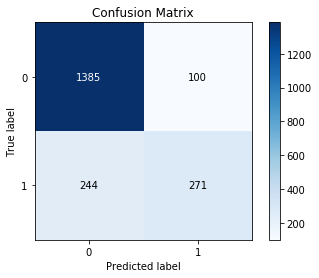

In [22]:
# Show confusion matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

skplt.metrics.plot_confusion_matrix(y_test.values.astype(np.int64), preds)
plt.show()